In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import PIL

import tensorflow as tf
import tensorflow.keras.preprocessing.image as image
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.optimizers as optimizers

import matplotlib.pyplot as plt
%matplotlib inline

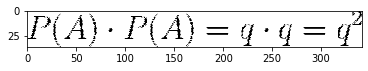

In [3]:
image_path = list(Path('/data/images-small/').rglob('*.png'))[100]
img = PIL.Image.open(image_path)
data = np.asarray(img)
plt.imshow(data, cmap='Greys')

In [6]:
image_dirname = Path('/data/images-small/')
data_generator = image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    horizontal_flip=False,
    vertical_flip=False,
    validation_split=0.1,
)

In [7]:
dgen_args = {
    'directory': image_dirname,
    'target_size': (64, 128),
    'class_mode': 'sparse',
    'batch_size': 512,
    'shuffle': True,
    'color_mode': 'grayscale'
}

train_dg = data_generator.flow_from_directory(subset='training', **dgen_args)
val_dg = data_generator.flow_from_directory(subset='validation', **dgen_args)

n_batches = len(train_dg)
trainX = []
for i in range(500):
    batch = train_dg.next()
    trainX.append(batch[0])
trainX = np.concatenate(trainX, axis=0)
data_generator.fit(trainX)

train_dg = data_generator.flow_from_directory(subset='training', **dgen_args)
val_dg = data_generator.flow_from_directory(subset='validation', **dgen_args)

Found 22683 images belonging to 3 classes.
Found 2520 images belonging to 3 classes.
Found 22683 images belonging to 3 classes.
Found 2520 images belonging to 3 classes.


batch mean: -0.0017
batch std: 1.0015
batch shape: (512, 64, 128, 1)
Standard Normal: True


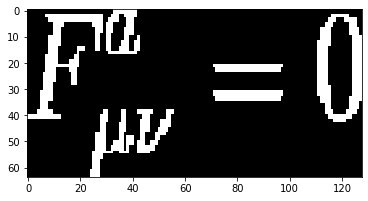

In [8]:
batch = train_dg.next()
X = batch[0]
print(f'batch mean: {X.mean():0.4f}')
print(f'batch std: {X.std():0.4f}')
print(f'batch shape: {X.shape}')
m, s = X.mean(), X.std()
print(f'Standard Normal: {(np.isclose(m,0, atol=0.1)) and (np.isclose(s, 1, atol=0.1))}')
plt.imshow(X[0, ..., 0], cmap='Greys')
plt.show()

In [9]:
def cv_model():
    input_shape = (64, 128, 1)
    input = layers.Input(shape=input_shape)
    tmp = input
    for i in range(5):
        #conv = layers.Conv2D(64*(2**i), 3, activation='relu', kernel_initializer='he_uniform', padding='same')(tmp)
        conv = layers.Conv2D(64*(2**i), 3, padding='same')(tmp)
        norm = layers.BatchNormalization()(conv)
        activ = layers.Activation('relu')(norm)
        pool = layers.MaxPooling2D(3, padding='same')(activ)
        tmp = pool
    flat = layers.Flatten()(tmp)
    for i in range(3):
        #flat = layers.Dense(256//(2**i), activation='relu', kernel_initializer='he_uniform')(flat)
        flat = layers.Dense(256//(2**i))(flat)
        norm = layers.BatchNormalization()(flat)
        activ = layers.Activation('relu')(norm)
        flat = activ
    output = layers.Dense(3, activation='softmax')(flat)
    model = models.Model(input, output)
    return model

def compile_model(model):
    opt = optimizers.Adam(0.01)
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=opt,
        metrics=['sparse_categorical_accuracy']
    )
    return model

In [19]:
model = cv_model()
model = compile_model(model)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 128, 1)]      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 128, 64)       640       
_________________________________________________________________
batch_normalization_8 (Batch (None, 64, 128, 64)       256       
_________________________________________________________________
activation_8 (Activation)    (None, 64, 128, 64)       0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 43, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 43, 128)       73856     
_________________________________________________________________
batch_normalization_9 (Batch (None, 22, 43, 128)       512 

In [12]:
history = model.fit_generator(
    train_dg,
    steps_per_epoch=len(train_dg),
    validation_data=val_dg,
    validation_steps=len(val_dg),
    epochs=24,
    shuffle=True
)

Epoch 1/24
45/45 [==============================] - 29s 647ms/step - loss: 1.0231 - sparse_categorical_accuracy: 0.4899 - val_loss: 12.9197 - val_sparse_categorical_accuracy: 0.3968
Epoch 2/24
45/45 [==============================] - 26s 571ms/step - loss: 0.9996 - sparse_categorical_accuracy: 0.5170 - val_loss: 4.1352 - val_sparse_categorical_accuracy: 0.3968
Epoch 3/24
45/45 [==============================] - 26s 572ms/step - loss: 0.9717 - sparse_categorical_accuracy: 0.5417 - val_loss: 2.9909 - val_sparse_categorical_accuracy: 0.3968
Epoch 4/24
45/45 [==============================] - 26s 569ms/step - loss: 0.9481 - sparse_categorical_accuracy: 0.5557 - val_loss: 1.1299 - val_sparse_categorical_accuracy: 0.4286
Epoch 5/24
45/45 [==============================] - 26s 569ms/step - loss: 0.9300 - sparse_categorical_accuracy: 0.5662 - val_loss: 1.1090 - val_sparse_categorical_accuracy: 0.4365
Epoch 6/24
45/45 [==============================] - 26s 569ms/step - loss: 0.9035 - sparse_cat

In [26]:
def summarize_diagnostics(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='test')
    plt.show()
    plt.close()

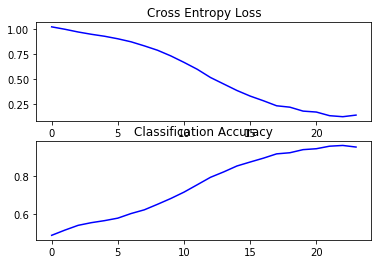

In [16]:
summarize_diagnostics(history)

In [21]:
history1 = model.fit_generator(
    train_dg,
    steps_per_epoch=len(train_dg),
    validation_data=val_dg,
    validation_steps=len(val_dg),
    epochs=30,
    shuffle=True
)

Epoch 1/30
45/45 [==============================] - 26s 576ms/step - loss: 1.0388 - sparse_categorical_accuracy: 0.4782 - val_loss: 36.3161 - val_sparse_categorical_accuracy: 0.3972
Epoch 2/30
45/45 [==============================] - 26s 575ms/step - loss: 0.9934 - sparse_categorical_accuracy: 0.5227 - val_loss: 6.6183 - val_sparse_categorical_accuracy: 0.3968
Epoch 3/30
45/45 [==============================] - 26s 573ms/step - loss: 0.9746 - sparse_categorical_accuracy: 0.5380 - val_loss: 1.4584 - val_sparse_categorical_accuracy: 0.4179
Epoch 4/30
45/45 [==============================] - 26s 570ms/step - loss: 0.9482 - sparse_categorical_accuracy: 0.5531 - val_loss: 1.0227 - val_sparse_categorical_accuracy: 0.5155
Epoch 5/30
45/45 [==============================] - 26s 572ms/step - loss: 0.9241 - sparse_categorical_accuracy: 0.5709 - val_loss: 1.0925 - val_sparse_categorical_accuracy: 0.4032
Epoch 6/30
45/45 [==============================] - 26s 572ms/step - loss: 0.8975 - sparse_cat

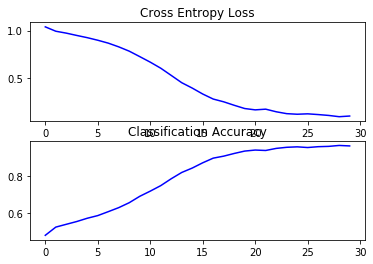

In [25]:
summarize_diagnostics(history1)

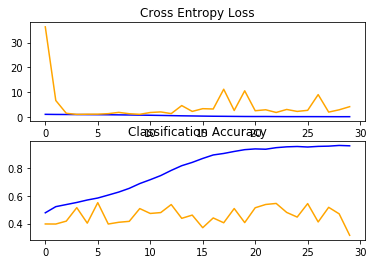

In [27]:
summarize_diagnostics(history1)

# analysis

In [29]:
!pip install sklearn

     |████████████████████████████████| 6.7MB 4.4MB/s eta 0:00:01     |██████████████████▍             | 3.8MB 4.4MB/s eta 0:00:01
     |████████████████████████████████| 286kB 62.6MB/s eta 0:00:01
  Stored in directory: /home/koosterb/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [98]:
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

%matplotlib notebook

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    print(classes)
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [90]:
def predict_on_df(model, dg, df):
    #dg = image.ImageDataGenerator(df, batch_size=32, shuffle=False)
    yhat = model.predict_generator(dg)
    pred_index = yhat.argmax(axis=1)
    pred_conf = yhat.max(axis=1)
    df['pred_index'] = pred_index
    df['pred_label'] = df.pred_index.apply(lambda x: list(dg.class_indices.keys())[x])
    df['pred_conf'] = pred_conf
    df['match'] = df['pred_index'] == df['label']
    return df


def display_top_losses(prediction_df, k: int = 10):
    wrong_condition = ~prediction_df.match
    wrong_df = prediction_df[wrong_condition]
    return wrong_df.sort_values('pred_conf', ascending=False).iloc[0:k][['equation', 'pred_label', 'source', 'pred_index', 'label', 'pred_conf']]

In [91]:
import pandas as pd

output = pd.DataFrame()

labels = np.empty(2520)
index = 0
for i in range(len(val_dg)):
    vals = val_dg[i][1]
    for val in vals:
        labels[index] = val
        index += 1
        
output['label'] = labels

In [92]:
predictions = predict_on_df(model, val_dg, output)

[0 1 2]
Confusion matrix, without normalization
[[438  40  42]
 [784 160  56]
 [782  22 196]]


<IPython.core.display.Javascript object>


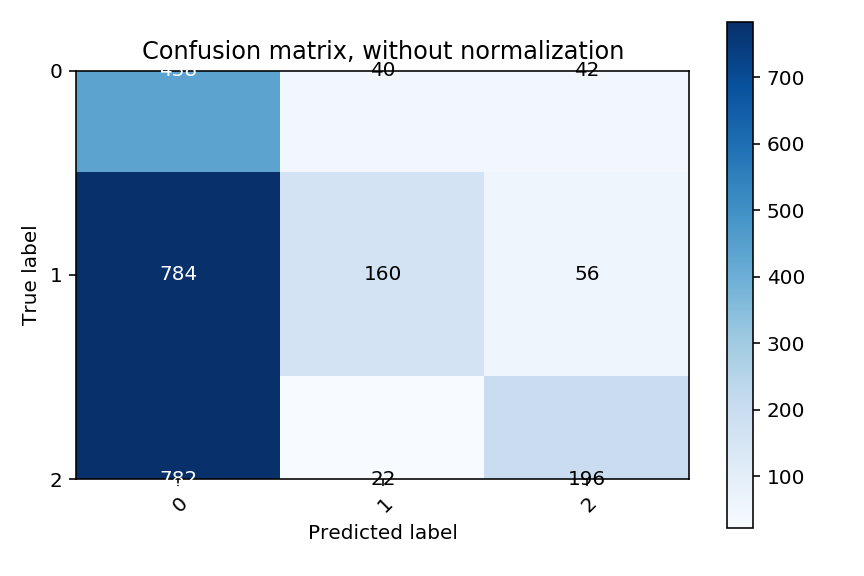

In [100]:
plot_confusion_matrix(predictions.label, predictions.pred_index, np.array(list(val_dg.class_indices.values())))